In [ ]:
!pip install pillow

In [ ]:
from pathlib import Path
from PIL import Image
import zipfile, io, time, re

In [ ]:
# Input and output folders (created if missing)
INPUT_DIR  = Path("input_pngs")
OUTPUT_DIR = Path("colored_output")

# Your target colors (hex)
TARGET_COLORS = [
    "#232642",
    "#32213a",
    "#3d1e28",
    "#063126",
    "#322807",
    "#3e1e1f",
    "#002f39",
    "#152a41",
]

# How to attach the color to the filename:
# e.g., original icon.png -> icon__232642.png
FILENAME_JOINER = "__"   # separator before the hex (without #)


In [ ]:
def normalize_hex(color: str) -> str:
    """
    Validates and normalizes a hex color to the form '#RRGGBB'
    and returns the 6-digit uppercase hex (without #) for filenames.
    """
    if not isinstance(color, str):
        raise ValueError(f"Color must be a string, got {type(color)}")
    c = color.strip()
    if not c.startswith("#"):
        raise ValueError(f"Color must start with #: {color}")
    if not re.fullmatch(r"#[0-9A-Fa-f]{6}", c):
        raise ValueError(f"Color must be in #RRGGBB format: {color}")
    return c[1:].upper()


In [ ]:
def recolor_white_on_transparent(img: Image.Image, color_hex: str) -> Image.Image:
    """
    Given a white shape on transparent background, recolor to color_hex.

    - Extract the alpha channel from the original.
    - Create a solid RGBA image filled with the target color and apply the original alpha.
    """
    if img.mode != "RGBA":
        img = img.convert("RGBA")
    *_, alpha = img.split()  # keep only the alpha channel

    # Make a solid color image
    rgb_hex = normalize_hex(color_hex)  # 'RRGGBB'
    r = int(rgb_hex[0:2], 16)
    g = int(rgb_hex[2:4], 16)
    b = int(rgb_hex[4:6], 16)

    colored = Image.new("RGBA", img.size, (r, g, b, 255))
    colored.putalpha(alpha)  # reuse original transparency
    return colored


In [ ]:
# Ensure folders exist
INPUT_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

pngs = sorted([p for p in INPUT_DIR.glob("*.png")])
if not pngs:
    print(f"No PNGs found in {INPUT_DIR.resolve()}. Add files and re-run this cell.")
else:
    print(f"Found {len(pngs)} PNG(s) in {INPUT_DIR.resolve()}.")

written = []
for src in pngs:
    try:
        img = Image.open(src)
    except Exception as e:
        print(f"Skipping {src.name}: cannot open ({e})")
        continue

    stem = src.stem
    for col in TARGET_COLORS:
        hex_for_name = normalize_hex(col)  # RRGGBB
        out_name = f"{stem}{FILENAME_JOINER}{hex_for_name}.png"
        out_path = OUTPUT_DIR / out_name

        try:
            recolored = recolor_white_on_transparent(img, col)
            recolored.save(out_path, format="PNG")
            written.append(out_path)
        except Exception as e:
            print(f"Failed {src.name} -> {out_name}: {e}")

print(f"Done. Wrote {len(written)} file(s) to {OUTPUT_DIR.resolve()}.")


Found 10 PNG(s) in /content/input_pngs.
Done. Wrote 80 file(s) to /content/colored_output.


In [ ]:
timestamp = time.strftime("%Y%m%d_%H%M%S")
zip_path = Path(f"colored_pngs_{timestamp}.zip")

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for file_path in sorted(OUTPUT_DIR.glob("*.png")):
        # Add with a relative path inside the zip (folder name retained)
        zf.write(file_path, arcname=str(Path(OUTPUT_DIR.name) / file_path.name))

print(f"ZIP created: {zip_path.resolve()}")


ZIP created: /content/colored_pngs_20251010_084712.zip


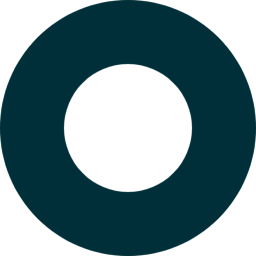

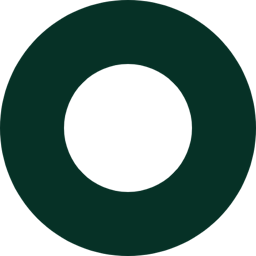

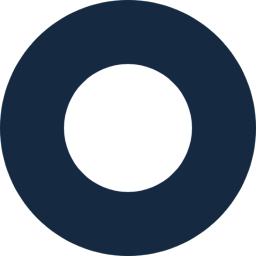

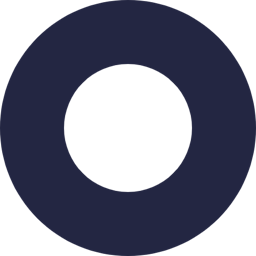

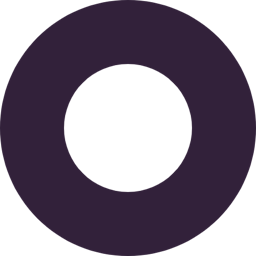

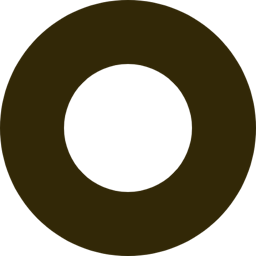

In [ ]:
from IPython.display import display

preview = list(sorted(OUTPUT_DIR.glob("*.png")))[:min(6, len(list(OUTPUT_DIR.glob('*.png'))))]
for p in preview:
    display(Image.open(p).resize((256, 256)))


In [ ]:
# Creates a CSV with all output PNG filenames (name only, including ".png")
# Saved as colored_file_list_YYYYMMDD_HHMMSS.csv next to the notebook.

import csv, time
from pathlib import Path

ts = time.strftime("%Y%m%d_%H%M%S")
csv_path = Path(f"colored_file_list_{ts}.csv")

png_names = [p.name for p in sorted(OUTPUT_DIR.glob("*.png"))]

with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["filename"])
    for name in png_names:
        writer.writerow([name])

print(f"CSV created: {csv_path.resolve()} with {len(png_names)} filenames.")


CSV created: /content/colored_file_list_20251010_090256.csv with 80 filenames.


In [ ]:
# Alternative: list PNG filenames from the ZIP itself
import csv
from pathlib import Path
import zipfile, time

ts = time.strftime("%Y%m%d_%H%M%S")
csv_zip_list = Path(f"zip_file_list_{ts}.csv")

with zipfile.ZipFile(zip_path, "r") as zf:
    png_in_zip = [n for n in zf.namelist() if n.lower().endswith(".png")]

with open(csv_zip_list, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["filename_in_zip"])
    for n in png_in_zip:
        writer.writerow([n])

print(f"CSV created: {csv_zip_list.resolve()} with {len(png_in_zip)} filenames from the ZIP.")
